# Data Quality

## Libraries and Files

In [8]:
# Data manipulation
import json
import pandas as pd
import numpy as np
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Fairness (optional but recommended)
# pip install fairlearn
from fairlearn.metrics import demographic_parity_difference
# MongoDB (if using)
from pymongo import MongoClient
from pathlib import Path


In [11]:
# Load the raw nested JSON file
with open("../data/raw_credit_applications.json", "r") as f:
    raw_data = json.load(f)

# Sanity check: how many records did we load?
print(f"Total records loaded: {len(raw_data)}")
print(f"Type of raw_ {type(raw_data)}")
print(f"\nFirst record (raw):")
print(json.dumps(raw_data[0], indent=2))


Total records loaded: 502
Type of raw_ <class 'list'>

First record (raw):
{
  "_id": "app_200",
  "applicant_info": {
    "full_name": "Jerry Smith",
    "email": "jerry.smith17@hotmail.com",
    "ssn": "596-64-4340",
    "ip_address": "192.168.48.155",
    "gender": "Male",
    "date_of_birth": "2001-03-09",
    "zip_code": "10036"
  },
  "financials": {
    "annual_income": 73000,
    "credit_history_months": 23,
    "debt_to_income": 0.2,
    "savings_balance": 31212
  },
  "spending_behavior": [
    {
      "category": "Shopping",
      "amount": 480
    },
    {
      "category": "Rent",
      "amount": 790
    },
    {
      "category": "Alcohol",
      "amount": 247
    }
  ],
  "decision": {
    "loan_approved": false,
    "rejection_reason": "algorithm_risk_score"
  },
  "processing_timestamp": "2024-01-15T00:00:00Z"
}


## File Preview


In [12]:
# Flatten the nested JSON: applicant_info, financials, and decision
# This turns nested keys like {"applicant_info": {"email": ...}} 
# into flat columns like "applicant_info.email"
df = pd.json_normalize(
    raw_data,
    record_path=None,       # No repeated record paths at the top level yet
    meta=[
        '_id',
        ['applicant_info', 'full_name'],
        ['applicant_info', 'email'],
        ['applicant_info', 'ssn'],
        ['applicant_info', 'ip_address'],
        ['applicant_info', 'gender'],
        ['applicant_info', 'date_of_birth'],
        ['applicant_info', 'zip_code'],
        ['financials', 'annual_income'],
        ['financials', 'credit_history_months'],
        ['financials', 'debt_to_income'],
        ['financials', 'savings_balance'],
        ['decision', 'loan_approved'],
        ['decision', 'interest_rate'],
        ['decision', 'approved_amount'],
        ['decision', 'rejection_reason'],
    ],
    errors='ignore'         # Don't crash if a field is missing in some records
)

print(f"DataFrame shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")


DataFrame shape: (502, 21)

Columns: ['_id', 'spending_behavior', 'processing_timestamp', 'applicant_info.full_name', 'applicant_info.email', 'applicant_info.ssn', 'applicant_info.ip_address', 'applicant_info.gender', 'applicant_info.date_of_birth', 'applicant_info.zip_code', 'financials.annual_income', 'financials.credit_history_months', 'financials.debt_to_income', 'financials.savings_balance', 'decision.loan_approved', 'decision.rejection_reason', 'loan_purpose', 'decision.interest_rate', 'decision.approved_amount', 'financials.annual_salary', 'notes']


In [14]:
# spending_behavior is an array of objects per record — it needs special handling
# We extract it separately and create a summary feature per applicant

spending_records = []

for record in raw_data:
    app_id = record.get('_id')
    spending = record.get('spending_behavior', [])
    
    # If spending_behavior exists and is a list, sum total monthly spend
    if isinstance(spending, list) and len(spending) > 0:
        total_spend = sum(
            item.get('amount', 0) for item in spending 
            if isinstance(item.get('amount'), (int, float))
        )
        categories = [item.get('category') for item in spending if item.get('category')]
    else:
        total_spend = np.nan
        categories = []
    
    spending_records.append({
        '_id': app_id,
        'total_monthly_spend': total_spend,
        'spending_categories': categories,
        'num_spending_categories': len(categories)
    })

df_spending = pd.DataFrame(spending_records)

# Merge spending summary back into the main DataFrame
df = df.merge(df_spending, on='_id', how='left')

print(f"DataFrame shape after merging spending: {df.shape}")
print(df[['_id', 'total_monthly_spend', 'num_spending_categories']].head(5))


DataFrame shape after merging spending: (506, 24)
       _id  total_monthly_spend  num_spending_categories
0  app_200                 1517                        3
1  app_037                  947                        3
2  app_215                  109                        1
3  app_024                  575                        1
4  app_184                  463                        1


In [15]:
# --- Overview 1: Shape and column types ---
print("=== DATAFRAME INFO ===")
df.info()

=== DATAFRAME INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   _id                               506 non-null    object 
 1   spending_behavior                 506 non-null    object 
 2   processing_timestamp              62 non-null     object 
 3   applicant_info.full_name          506 non-null    object 
 4   applicant_info.email              506 non-null    object 
 5   applicant_info.ssn                500 non-null    object 
 6   applicant_info.ip_address         500 non-null    object 
 7   applicant_info.gender             504 non-null    object 
 8   applicant_info.date_of_birth      504 non-null    object 
 9   applicant_info.zip_code           504 non-null    object 
 10  financials.annual_income          501 non-null    object 
 11  financials.credit_history_months  506 non-null  

In [16]:
# --- Overview 2: Summary statistics for numeric columns ---
print("=== NUMERIC SUMMARY ===")
df.describe()

=== NUMERIC SUMMARY ===


,financials.credit_history_months,financials.debt_to_income,financials.savings_balance,decision.interest_rate,decision.approved_amount,financials.annual_salary,total_monthly_spend,num_spending_categories
count,506.000000,506.000000,506.000000,292.000000,292.000000,5.000000,506.000000,506.000000
mean,50.320158,0.247530,29323.492095,4.564726,47845.890411,69200.000000,789.096838,1.646245
std,31.125684,0.136578,16832.169918,1.162866,18103.754530,22664.950915,476.866410,0.749492
min,-10.000000,0.050000,-5000.000000,2.500000,15000.000000,45000.000000,60.000000,1.000000
25%,28.000000,0.150000,17105.500000,3.500000,34000.000000,46000.000000,443.250000,1.000000
50%,48.000000,0.230000,27285.000000,4.550000,48000.000000,75000.000000,729.500000,1.000000
75%,71.750000,0.350000,38153.500000,5.600000,62250.000000,86000.000000,1073.250000,2.000000
max,133.000000,1.850000,88078.000000,6.500000,80000.000000,94000.000000,2441.000000,4.000000


## Missing Values 

In [17]:
# --- Overview 3: Missing values per column ---
missing = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df) * 100).round(2)

missing_report = pd.DataFrame({
    'missing_count': missing,
    'missing_pct': missing_pct
}).sort_values('missing_pct', ascending=False)

print("=== MISSING VALUES REPORT ===")
print(missing_report[missing_report['missing_count'] > 0])

=== MISSING VALUES REPORT ===
                              missing_count  missing_pct
notes                                   502        99.21
financials.annual_salary                501        99.01
loan_purpose                            456        90.12
processing_timestamp                    444        87.75
decision.rejection_reason               292        57.71
decision.approved_amount                214        42.29
decision.interest_rate                  214        42.29
applicant_info.ssn                        6         1.19
applicant_info.ip_address                 6         1.19
financials.annual_income                  5         0.99
applicant_info.gender                     2         0.40
applicant_info.date_of_birth              2         0.40
applicant_info.zip_code                   2         0.40


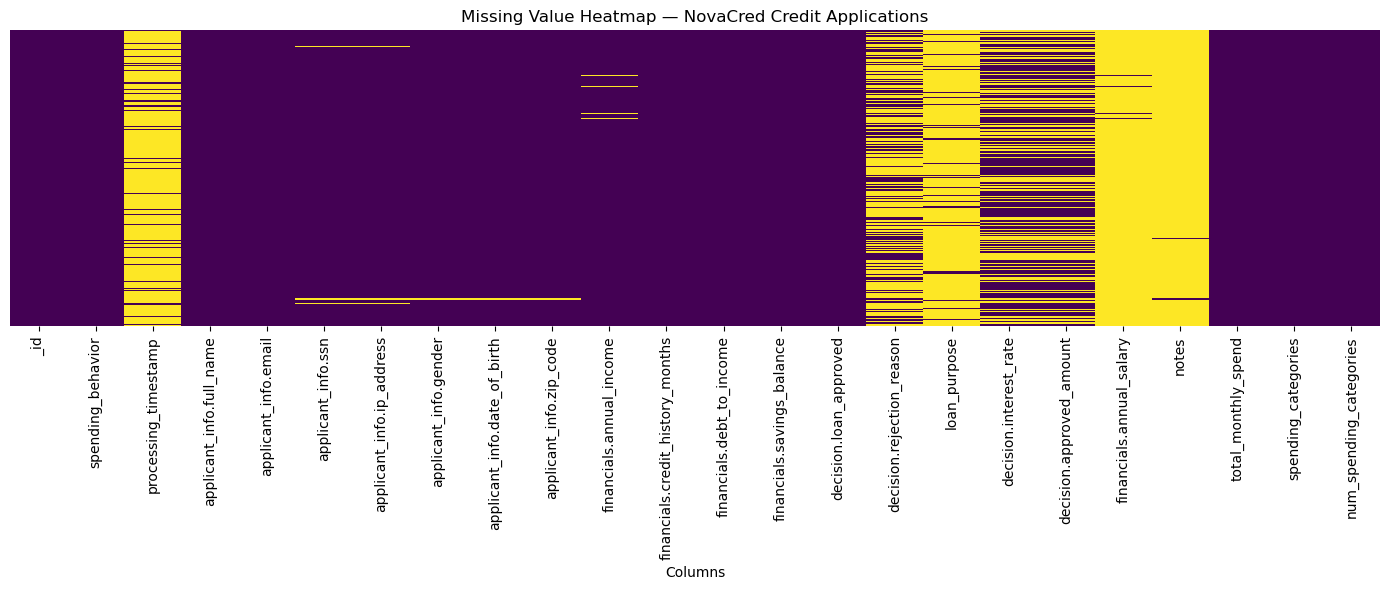

In [ ]:
# Heatmap of missing values — great visual for your video presentation
plt.figure(figsize=(14, 6))
sns.heatmap(
    df.isnull(),
    cbar=False,
    yticklabels=False,
    cmap='viridis'
)
plt.title('Missing Value Heatmap — NovaCred Credit Applications')
plt.xlabel('Columns')
plt.tight_layout()
plt.show()


## Unique values

In [20]:
# Check for inconsistent coding in categorical fields
categorical_cols = [
    'applicant_info.gender',
    'decision.loan_approved',
    'decision.rejection_reason'
]

for col in categorical_cols:
    if col in df.columns:
        print(f"\n=== '{col}' unique values ===")
        print(df[col].value_counts(dropna=False))



=== 'applicant_info.gender' unique values ===
applicant_info.gender
Male      197
Female    194
F          58
M          53
            2
NaN         2
Name: count, dtype: int64

=== 'decision.loan_approved' unique values ===
decision.loan_approved
True     292
False    214
Name: count, dtype: int64

=== 'decision.rejection_reason' unique values ===
decision.rejection_reason
NaN                            292
algorithm_risk_score           172
insufficient_credit_history     23
high_dti_ratio                  15
low_income                       4
Name: count, dtype: int64


In [21]:
# Check for inconsistent date formats in date_of_birth
print("=== Sample date_of_birth values ===")
print(df['applicant_info.date_of_birth'].dropna().head(20).tolist())

# Attempt to parse — errors='coerce' turns unparseable values into NaT
df['dob_parsed'] = pd.to_datetime(df['applicant_info.date_of_birth'], errors='coerce')

# How many failed to parse? Those are the problematic formats
failed_parse = df['dob_parsed'].isnull().sum()
total_with_dob = df['applicant_info.date_of_birth'].notna().sum()
print(f"\nFailed to auto-parse: {failed_parse} out of {total_with_dob} records")
print("\nSample of records that failed parsing:")
print(df[df['dob_parsed'].isnull()]['applicant_info.date_of_birth'].dropna().head(10))


=== Sample date_of_birth values ===
['2001-03-09', '1992-03-31', '1989-10-24', '1983-04-25', '1999-05-21', '14/02/1982', '28/01/1990', '1991-10-11', '1990-05-04', '1990-05-04', '1989-10-10', '1970-10-01', '01/12/1978', '1989-06-13', '1976-04-19', '1990/07/26', '1992-06-22', '1997-03-23', '1989-10-07', '1962-08-26']

Failed to auto-parse: 163 out of 504 records

Sample of records that failed parsing:
5     14/02/1982
6     28/01/1990
12    01/12/1978
15    1990/07/26
22    18/07/1979
24    20/04/1979
27              
33    1986/11/20
36    1995/05/07
37    03/20/1968
Name: applicant_info.date_of_birth, dtype: object


## Data Cleaning

In [23]:
# ============================================================
# ISSUE 1: Duplicate Records (list-column safe version)
# ============================================================

# Identify columns that contain lists (unhashable types)
list_cols = [col for col in df.columns 
             if df[col].apply(lambda x: isinstance(x, list)).any()]

print(f"Columns containing lists (excluded from duplicate check): {list_cols}")

# Check for fully duplicated rows — exclude list-type columns
cols_for_dedup = [col for col in df.columns if col not in list_cols]
full_dupes = df[cols_for_dedup].duplicated().sum()
print(f"\nFully duplicated rows (excluding list cols): {full_dupes} "
      f"({full_dupes/len(df)*100:.2f}%)")

# Check for duplicate application IDs (_id is a string — always safe)
id_dupes = df['_id'].duplicated().sum()
print(f"Duplicate _id values: {id_dupes} ({id_dupes/len(df)*100:.2f}%)")

# Show the actual duplicate records
if id_dupes > 0:
    duped_ids = df[df['_id'].duplicated(keep=False)].sort_values('_id')
    print(f"\nDuplicate records:")
    print(duped_ids[['_id', 'applicant_info.full_name',
                      'financials.annual_income',
                      'decision.loan_approved']].to_string())
else:
    print("\nNo duplicate _id values found.")


Columns containing lists (excluded from duplicate check): ['spending_behavior', 'spending_categories']

Fully duplicated rows (excluding list cols): 4 (0.79%)
Duplicate _id values: 6 (1.19%)

Duplicate records:
         _id applicant_info.full_name financials.annual_income  decision.loan_approved
385  app_001         Stephanie Nguyen                   102000                   False
386  app_001         Stephanie Nguyen                   102000                   False
458  app_001         Stephanie Nguyen                   102000                   False
459  app_001         Stephanie Nguyen                   102000                   False
8    app_042             Joseph Lopez                    69000                   False
9    app_042             Joseph Lopez                    69000                   False
355  app_042             Joseph Lopez                    69000                   False
356  app_042             Joseph Lopez                    69000                   False


Excluding the spending_behavior and spending_categories as they are not relevant for duplicates check. 

In [24]:
# ============================================================
# ISSUE 2: Missing / Incomplete Records
# ============================================================

# Per-column missing value report (built on what you started in Step 2)
missing_count = df.isnull().sum()
missing_pct = (missing_count / len(df) * 100).round(2)

missing_report = pd.DataFrame({
    'missing_count': missing_count,
    'missing_pct': missing_pct
}).sort_values('missing_pct', ascending=False)

print("=== MISSING VALUES REPORT ===")
print(missing_report[missing_report['missing_count'] > 0].to_string())


=== MISSING VALUES REPORT ===
                              missing_count  missing_pct
notes                                   502        99.21
financials.annual_salary                501        99.01
loan_purpose                            456        90.12
processing_timestamp                    444        87.75
decision.rejection_reason               292        57.71
decision.interest_rate                  214        42.29
decision.approved_amount                214        42.29
dob_parsed                              163        32.21
applicant_info.ip_address                 6         1.19
applicant_info.ssn                        6         1.19
financials.annual_income                  5         0.99
applicant_info.gender                     2         0.40
applicant_info.zip_code                   2         0.40
applicant_info.date_of_birth              2         0.40


In [25]:
# Identify records that are critically incomplete:
# missing core financial fields needed for a credit decision
critical_fields = [
    'financials.annual_income',
    'financials.debt_to_income',
    'financials.credit_history_months',
    'decision.loan_approved'
]

# A record missing ANY of these is critically incomplete
critically_incomplete = df[critical_fields].isnull().any(axis=1).sum()
print(f"\nCritically incomplete records (missing ≥1 core field): "
      f"{critically_incomplete} ({critically_incomplete/len(df)*100:.2f}%)")



Critically incomplete records (missing ≥1 core field): 5 (0.99%)


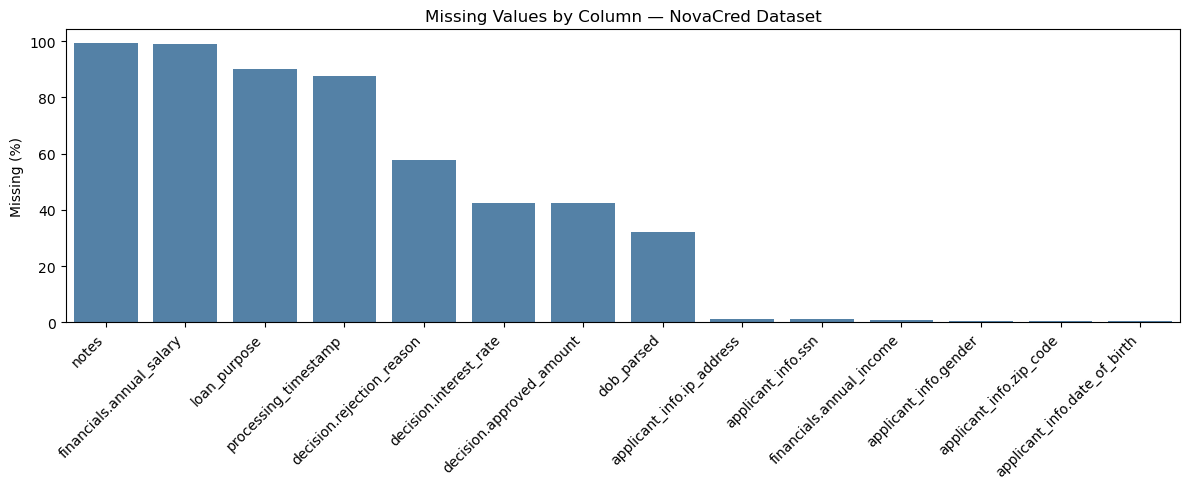

In [26]:
# Visualise: bar chart of missing values per column
missing_to_plot = missing_report[missing_report['missing_count'] > 0]

plt.figure(figsize=(12, 5))
sns.barplot(
    x=missing_to_plot.index, 
    y=missing_to_plot['missing_pct'],
    color='steelblue'
)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Missing (%)')
plt.title('Missing Values by Column — NovaCred Dataset')
plt.tight_layout()
plt.show()


In [27]:
# ============================================================
# ISSUE 3: Inconsistent Data Types
# ============================================================

# These columns SHOULD be numeric — check if pandas inferred them as 'object' (string)
numeric_cols = [
    'financials.annual_income',
    'financials.credit_history_months',
    'financials.debt_to_income',
    'financials.savings_balance',
    'decision.interest_rate',
    'decision.approved_amount'
]

print("=== DATA TYPE AUDIT (expected: numeric) ===")
for col in numeric_cols:
    if col in df.columns:
        dtype = df[col].dtype
        flag = "PROBLEM" if dtype == 'object' else "OK"
        print(f"  {col:<45} dtype={dtype}  {flag}")


=== DATA TYPE AUDIT (expected: numeric) ===
  financials.annual_income                      dtype=object  PROBLEM
  financials.credit_history_months              dtype=int64  OK
  financials.debt_to_income                     dtype=float64  OK
  financials.savings_balance                    dtype=int64  OK
  decision.interest_rate                        dtype=float64  OK
  decision.approved_amount                      dtype=float64  OK


In [28]:
# For any column stored as 'object' that should be numeric,
# try a forced conversion and count how many values fail
print("\n=== NON-NUMERIC VALUES IN NUMERIC COLUMNS ===")
for col in numeric_cols:
    if col in df.columns and df[col].dtype == 'object':
        # coerce forces non-numeric strings to NaN
        converted = pd.to_numeric(df[col], errors='coerce')
        bad_count = converted.isnull().sum() - df[col].isnull().sum()
        bad_values = df[col][pd.to_numeric(df[col], errors='coerce').isnull() 
                             & df[col].notna()].unique()
        print(f"\n  '{col}': {bad_count} non-numeric value(s) found")
        print(f"  Sample bad values: {bad_values[:5]}")



=== NON-NUMERIC VALUES IN NUMERIC COLUMNS ===

  'financials.annual_income': 0 non-numeric value(s) found
  Sample bad values: []


In [29]:
# Also check loan_approved — it should be Boolean (True/False)
# but may be stored as strings like "true", "yes", "1", "approved"
print("\n=== loan_approved unique raw values ===")
print(df['decision.loan_approved'].value_counts(dropna=False))


=== loan_approved unique raw values ===
decision.loan_approved
True     292
False    214
Name: count, dtype: int64


In [30]:
# ============================================================
# ISSUE 4: Inconsistent Categorical Coding
# ============================================================

# Gender is the most critical field — it drives the DI ratio calculation
# and is a protected attribute under GDPR and anti-discrimination law
print("=== GENDER FIELD — raw unique values ===")
gender_counts = df['applicant_info.gender'].value_counts(dropna=False)
print(gender_counts)
print(f"\nTotal unique raw values: {df['applicant_info.gender'].nunique(dropna=True)}")


=== GENDER FIELD — raw unique values ===
applicant_info.gender
Male      197
Female    194
F          58
M          53
            2
NaN         2
Name: count, dtype: int64

Total unique raw values: 5


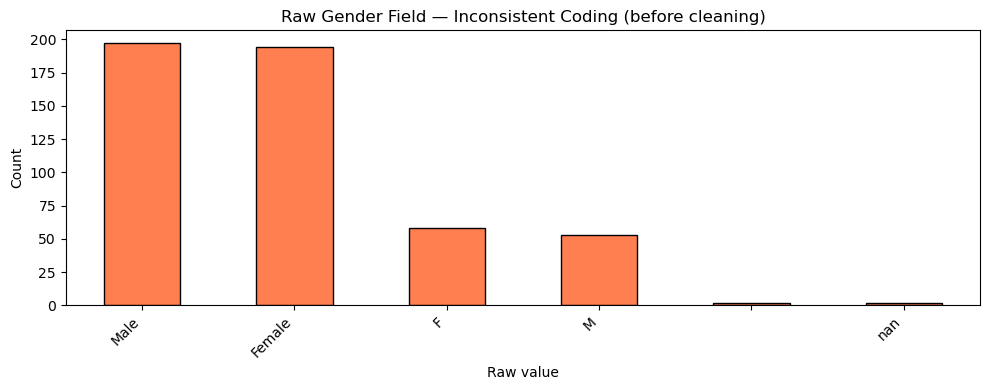

In [31]:
# Show the problem visually
plt.figure(figsize=(10, 4))
gender_counts.plot(kind='bar', color='coral', edgecolor='black')
plt.title('Raw Gender Field — Inconsistent Coding (before cleaning)')
plt.xlabel('Raw value')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [32]:
# Also check rejection_reason for inconsistent wording
# e.g., "low income" vs "Low Income" vs "INCOME_TOO_LOW"
print("\n=== rejection_reason — raw unique values ===")
print(df['decision.rejection_reason'].value_counts(dropna=False).to_string())


=== rejection_reason — raw unique values ===
decision.rejection_reason
NaN                            292
algorithm_risk_score           172
insufficient_credit_history     23
high_dti_ratio                  15
low_income                       4


In [33]:
# ============================================================
# ISSUE 5: Invalid / Impossible Values
# ============================================================

# First, ensure numeric columns are actually numeric for comparison
# (use coerce so we don't crash on strings)
df['income_numeric'] = pd.to_numeric(df['financials.annual_income'], errors='coerce')
df['credit_hist_numeric'] = pd.to_numeric(df['financials.credit_history_months'], errors='coerce')
df['dti_numeric'] = pd.to_numeric(df['financials.debt_to_income'], errors='coerce')
df['savings_numeric'] = pd.to_numeric(df['financials.savings_balance'], errors='coerce')

validity_issues = {}

# Rule 1: credit_history_months cannot be negative
neg_credit = (df['credit_hist_numeric'] < 0).sum()
validity_issues['Negative credit_history_months'] = neg_credit
print(f"Negative credit_history_months: {neg_credit} ({neg_credit/len(df)*100:.2f}%)")
if neg_credit > 0:
    print(df[df['credit_hist_numeric'] < 0][['_id', 'financials.credit_history_months']].head())


Negative credit_history_months: 2 (0.40%)
         _id  financials.credit_history_months
138  app_043                               -10
163  app_156                                -3


In [34]:
# Rule 2: debt_to_income should be between 0 and 1 (or possibly up to ~2 for extreme cases)
# Values > 1 mean debt exceeds income — flag > 1 as suspicious, > 2 as invalid
extreme_dti = (df['dti_numeric'] > 1).sum()
impossible_dti = (df['dti_numeric'] > 2).sum()
validity_issues['DTI > 1.0 (debt exceeds income)'] = extreme_dti
validity_issues['DTI > 2.0 (likely invalid)'] = impossible_dti
print(f"\nDebt-to-income > 1.0: {extreme_dti} ({extreme_dti/len(df)*100:.2f}%)")
print(f"Debt-to-income > 2.0: {impossible_dti} ({impossible_dti/len(df)*100:.2f}%)")



Debt-to-income > 1.0: 1 (0.20%)
Debt-to-income > 2.0: 0 (0.00%)


In [35]:
# Rule 3: annual_income cannot be zero or negative
bad_income = (df['income_numeric'] <= 0).sum()
validity_issues['Zero or negative annual_income'] = bad_income
print(f"\nZero or negative annual_income: {bad_income} ({bad_income/len(df)*100:.2f}%)")



Zero or negative annual_income: 1 (0.20%)


In [36]:
# Rule 4: savings_balance cannot be negative (it's a balance, not a position)
neg_savings = (df['savings_numeric'] < 0).sum()
validity_issues['Negative savings_balance'] = neg_savings
print(f"\nNegative savings_balance: {neg_savings} ({neg_savings/len(df)*100:.2f}%)")



Negative savings_balance: 1 (0.20%)


In [37]:
# Rule 5: interest_rate should be a reasonable percentage — flag > 100% as impossible
# and flag approved loans with NO interest rate (should always have one)
if 'decision.interest_rate' in df.columns:
    rate_numeric = pd.to_numeric(df['decision.interest_rate'], errors='coerce')
    impossible_rate = (rate_numeric > 100).sum()
    approved_no_rate = (
        (df['decision.loan_approved'] == True) & rate_numeric.isnull()
    ).sum()
    validity_issues['Interest rate > 100%'] = impossible_rate
    validity_issues['Approved loan with no interest rate'] = approved_no_rate
    print(f"\nInterest rate > 100%: {impossible_rate}")
    print(f"Approved loans missing interest_rate: {approved_no_rate}")



Interest rate > 100%: 0
Approved loans missing interest_rate: 0


In [38]:
# Summary table of all validity issues found
print("\n=== VALIDITY ISSUES SUMMARY ===")
for issue, count in validity_issues.items():
    pct = count / len(df) * 100
    print(f"  {issue:<45} {count:>5} records  ({pct:.2f}%)")



=== VALIDITY ISSUES SUMMARY ===
  Negative credit_history_months                    2 records  (0.40%)
  DTI > 1.0 (debt exceeds income)                   1 records  (0.20%)
  DTI > 2.0 (likely invalid)                        0 records  (0.00%)
  Zero or negative annual_income                    1 records  (0.20%)
  Negative savings_balance                          1 records  (0.20%)
  Interest rate > 100%                              0 records  (0.00%)
  Approved loan with no interest rate               0 records  (0.00%)


In [39]:
# ============================================================
# ISSUE 6: Inconsistent Date Formats
# ============================================================

# Sample the raw values first to see what formats are present
print("=== Sample raw date_of_birth values (first 30) ===")
sample_dates = df['applicant_info.date_of_birth'].dropna().head(30).tolist()
for d in sample_dates:
    print(f"  {repr(d)}")


=== Sample raw date_of_birth values (first 30) ===
  '2001-03-09'
  '1992-03-31'
  '1989-10-24'
  '1983-04-25'
  '1999-05-21'
  '14/02/1982'
  '28/01/1990'
  '1991-10-11'
  '1990-05-04'
  '1990-05-04'
  '1989-10-10'
  '1970-10-01'
  '01/12/1978'
  '1989-06-13'
  '1976-04-19'
  '1990/07/26'
  '1992-06-22'
  '1997-03-23'
  '1989-10-07'
  '1962-08-26'
  '1997-02-25'
  '1981-10-27'
  '18/07/1979'
  '1961-11-04'
  '20/04/1979'
  '1978-02-16'
  '1989-08-01'
  ''
  '1997-12-09'
  '1985-01-03'


In [40]:
# Attempt auto-parsing — anything pandas can't understand becomes NaT
df['dob_parsed'] = pd.to_datetime(df['applicant_info.date_of_birth'], errors='coerce')

total_with_dob = df['applicant_info.date_of_birth'].notna().sum()
failed = df['dob_parsed'].isnull().sum()

print(f"\nTotal records with a date_of_birth value: {total_with_dob}")
print(f"Failed to parse: {failed} ({failed/len(df)*100:.2f}%)")

# Show the records that failed — these have non-standard formats
failed_dates = df[df['dob_parsed'].isnull() & 
                  df['applicant_info.date_of_birth'].notna()]['applicant_info.date_of_birth']
print(f"\nSample of unparseable date values:")
print(failed_dates.unique()[:15])



Total records with a date_of_birth value: 504
Failed to parse: 163 (32.21%)

Sample of unparseable date values:
['14/02/1982' '28/01/1990' '01/12/1978' '1990/07/26' '18/07/1979'
 '20/04/1979' '' '1986/11/20' '1995/05/07' '03/20/1968' '20/07/1997'
 '1987/06/28' '1988/04/06' '03/10/1981' '14/06/1975']


In [41]:
# Identify which distinct formats are present across the whole column
# This regex-based approach categorises the patterns
import re

def detect_date_format(date_str):
    """Classify a date string by its format pattern."""
    if pd.isnull(date_str):
        return 'NULL'
    s = str(date_str).strip()
    if re.match(r'^\d{4}-\d{2}-\d{2}$', s):
        return 'ISO (YYYY-MM-DD)'
    elif re.match(r'^\d{2}/\d{2}/\d{4}$', s):
        return 'EU (DD/MM/YYYY)'
    elif re.match(r'^\d{2}-\d{2}-\d{4}$', s):
        return 'EU dash (DD-MM-YYYY)'
    elif re.match(r'^\w+ \d{1,2}, \d{4}$', s):
        return 'Long (Month DD, YYYY)'
    elif re.match(r'^\d{2}\.\d{2}\.\d{4}$', s):
        return 'Dot (DD.MM.YYYY)'
    else:
        return f'Unknown: {s[:20]}'

df['dob_format'] = df['applicant_info.date_of_birth'].apply(detect_date_format)

print("\n=== DATE FORMAT DISTRIBUTION ===")
print(df['dob_format'].value_counts(dropna=False).to_string())



=== DATE FORMAT DISTRIBUTION ===
dob_format
ISO (YYYY-MM-DD)       343
EU (DD/MM/YYYY)        101
Unknown:                 4
NULL                     2
Unknown: 2000/05/22      1
Unknown: 1986/11/29      1
Unknown: 1980/12/21      1
Unknown: 1979/05/02      1
Unknown: 1964/02/22      1
Unknown: 1985/05/15      1
Unknown: 1997/03/01      1
Unknown: 1979/01/24      1
Unknown: 1963/01/29      1
Unknown: 1996/03/13      1
Unknown: 1991/02/04      1
Unknown: 1997/08/31      1
Unknown: 1984/12/27      1
Unknown: 1999/09/10      1
Unknown: 1974/08/23      1
Unknown: 1993/06/16      1
Unknown: 1970/04/15      1
Unknown: 1988/03/16      1
Unknown: 1971/03/31      1
Unknown: 2002/01/18      1
Unknown: 1994/03/21      1
Unknown: 1969/10/14      1
Unknown: 1993/11/17      1
Unknown: 1999/07/11      1
Unknown: 1977/12/24      1
Unknown: 2000/04/13      1
Unknown: 1977/07/31      1
Unknown: 2001/01/03      1
Unknown: 1993/12/27      1
Unknown: 1979/12/26      1
Unknown: 1990/07/26      1
Unknown: 1

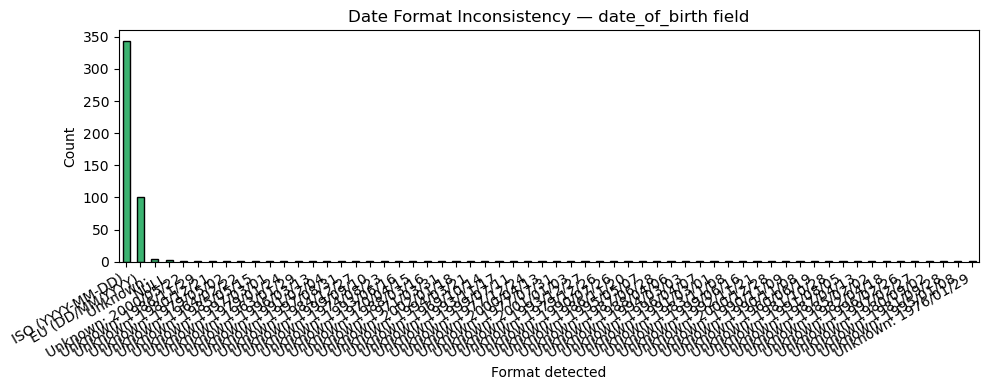

In [42]:
# Visualise format distribution
format_counts = df['dob_format'].value_counts()

plt.figure(figsize=(10, 4))
format_counts.plot(kind='bar', color='mediumseagreen', edgecolor='black')
plt.title('Date Format Inconsistency — date_of_birth field')
plt.xlabel('Format detected')
plt.ylabel('Count')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


In [43]:
# ============================================================
# DATA QUALITY AUDIT — CONSOLIDATED SUMMARY
# ============================================================

summary = {
    'Duplicate records (_id)':         id_dupes,
    'Fully duplicated rows':            full_dupes,
    'Critically incomplete records':    critically_incomplete,
    'Columns with missing values':      (missing_count > 0).sum(),
    'Type mismatches (numeric as str)': sum(1 for c in numeric_cols 
                                           if c in df.columns 
                                           and df[c].dtype == 'object'),
    'Inconsistent gender codes':        df['applicant_info.gender'].nunique(dropna=True),
    'Negative credit_history_months':   neg_credit,
    'Invalid DTI (> 1.0)':              extreme_dti,
    'Date format variants':             df['dob_format'].nunique() - 1,  # subtract NULL
}

print("=" * 60)
print("   DATA QUALITY AUDIT — NOVACRED DATASET")
print("=" * 60)
for issue, count in summary.items():
    print(f"  {issue:<45} {count:>6}")
print("=" * 60)
print(f"  Total records in dataset:                         {len(df):>6}")

# Save the full audited DataFrame (with all diagnostic columns) for Step 4
df.to_csv('../data/audited_with_diagnostics.csv', index=False)
print("\nAudited DataFrame saved to ../data/audited_with_diagnostics.csv")


   DATA QUALITY AUDIT — NOVACRED DATASET
  Duplicate records (_id)                            6
  Fully duplicated rows                              4
  Critically incomplete records                      5
  Columns with missing values                       14
  Type mismatches (numeric as str)                   1
  Inconsistent gender codes                          5
  Negative credit_history_months                     2
  Invalid DTI (> 1.0)                                1
  Date format variants                              59
  Total records in dataset:                            506

Audited DataFrame saved to ../data/audited_with_diagnostics.csv
